## Authors: Aishwarya Mathew, Vikram Yabannavar

# SPAMIFIER

## Introduction

Data science is all around us. It is an interdisciplinary field of study that strives to discover meaning behind data. Finding a good first data science project to work on is a hard task. You may know a lot of data science concepts but you get stuck when you want to apply your skills to real world tasks. However, you've come to the right place! Have you ever wanted to make an application that could distinguish between some bad thing and a good thing? This tutorial will do just that. It's actually a basic introduction to the world of data science. This project will teach you how to perform text classification by creating a spam classifier/filter that will distinguish between spam vs. not spam (we call this ham) SMS messages and emails. We will take you through the entire data science lifecycle which includes data collection, data processing, exploratory data analysis and visualization, hypothesis testing, machine learning and insight/policy decision.

### Tutorial Content

In this tutorial, you will learn how to build a text classifier using Scikit-Learn. Scikit-Learn is a popular open source Python library used for machine learning purposes.

The spam and ham data for our tutorial will come from a website called Kaggle which is a huge repository for different kinds of data.

This tutorial will go over the following topics:

* [Importing Libraries](#libraries)
<br>
* [Loading Data](#load data)
<br>
 - [SMS Data](#sms1)
<br>
 - [Email Data](#email1)
<br>
* [Processing Data](#process data)
<br>
 - [SMS Data](#sms2)
<br>
 - [Email Data](#email2)
<br>
* [Exploratory Analysis and Data Visualization](#eda)
<br>
 - [SMS Messages](#spam1)
<br>
 - [Email Messages](#spam2)

<a id='libraries'></a>
## Importing Libraries

Before getting started, you will need to import these libraries which we will use throughout this tutorial.

In [237]:
# Import data manipulation and plotting libraries
import pandas as pd
import csv
import re
import string
import matplotlib.pyplot as plt
import numpy as np
# Import Scikit-Learn functions
from sklearn import cross_validation
from sklearn import svm
from sklearn import tree
from sklearn import ensemble
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn.neural_network import BernoulliRBM
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing

<a id='load data'></a>
## Loading Data 

The first step of any data science project is data collection. Kaggle is a dataset website that has a lot of real world data. To get started, you need to click on this link, https://www.kaggle.com/uciml/sms-spam-collection-dataset , to download the SMS spam vs. ham dataset from Kaggle to your local disk. You will have to create a user account on Kaggle to download any of their datasets. Once you have downloaded the 'spam.csv' file, you need to place that file in the same folder as this notebook. For email data, we will use the dataset provided by Andrew Ng's Machine Learning course at Stanford. That data can be found [here](http://openclassroom.stanford.edu/MainFolder/courses/MachineLearning/exercises/ex6materials/ex6DataEmails.zip). Again, after you've downloaded the zipped file, unzip the file and place the four resulting folders in the same folder as this notebook. Once placed, you can run txt_to_csv.py to generate a CSV file of all the files in those folders, or you can download 'email.csv' from the GitHub repository. 

Next, we will load both datasets into two different pandas dataframes.

<a id='sms1'></a>
### SMS Data

In [238]:
# Read the SMS data into a pandas dataframe
SMS_spamham_data = pd.read_csv("sms.csv", encoding='latin-1')
SMS_spamham_data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


<a id='email1'></a>
### Email Data

In [239]:
# Read the email data into a pandas dataframe
email_spamham_data = pd.read_csv("email.csv", encoding='latin-1')
email_spamham_data.head()

,class,message
0,spam,great parttime summer job display box credit a...
1,spam,auto insurance rate too high dear nlpeople m s...
2,spam,want best economical hunt vacation life want b...
3,spam,email million million email addresses want mon...
4,spam,amaze world record sex attention warn adult wa...


<a id='process data'></a>
## Processing Data

As you can see above, our data is not tidy. The SMS dataset has unknown values and unnecessary columns. So our next step is to prepare the data. In the code below, we will process the data to make them clean and easy to use.

<a id='sms2'></a>
### SMS Data

In [240]:
# Remove unnecessary columns
del SMS_spamham_data['Unnamed: 2']
del SMS_spamham_data['Unnamed: 3']
del SMS_spamham_data['Unnamed: 4']
# Rename the remaining two columns
SMS_spamham_data.columns = ['Spam or Ham','SMS Message']

# The resulting clean dataframe with our data
SMS_spamham_data.head()

### Check for missing values

,Spam or Ham,SMS Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<a id='email2'></a>
### Email Data

In [241]:
# Renaming the two columns for consistency
email_spamham_data.columns = ['Spam or Ham','Email']
email_spamham_data.head()

,Spam or Ham,Email
0,spam,great parttime summer job display box credit a...
1,spam,auto insurance rate too high dear nlpeople m s...
2,spam,want best economical hunt vacation life want b...
3,spam,email million million email addresses want mon...
4,spam,amaze world record sex attention warn adult wa...


<a id='eda'></a>
## Exploratory Analysis and Data Visualization

In this section we are going to analyze our processed data. We will look at the most common words that are found in SMS and email spam messages. We will do the same for ham messages. This will help us understand what distinguishes spam messages from ham messages. While we are doing this, we will also plot a few graphs that will help us visualize this data.

<a id='spam1'></a>
### SMS Messages

We start by analyzing SMS data.

#### Finding The Top 50 Frequently Used Words in Spam SMS Messages

##### Get frequency of words
First, we are going to get the frequency of all the different words used in spam SMS messages.

In [242]:
# Dictionaries of word -> num occurrences
spam_words = {} 
ham_words = {}

# For stripping punctuation
translator= str.maketrans('','',string.punctuation)

# First, we tokenize the words.
# To do this, we strip punctuation and split lines by spaces.
# Note that we do not convert to lowercase, so Free, free, and FREE 
# are all going to be different for our purposes.
# If a word isn't in it's respective dictionary (spam_words or ham_words),
# we add it with default value 1, otherwise we increment 
# the word's number of occurrences by 1. 

for item,row in SMS_spamham_data.iterrows():
    # Remove punctuation
    line = row['SMS Message'].translate(translator)
    # Split by space
    line = line.split()
    
    for word in line:
        # If a spam message, add it or increment count
        # in spam_words
        if row['Spam or Ham'] == 'spam':
            if word in spam_words:
                spam_words[word] = spam_words[word] + 1
            else:
                spam_words[word] = 1
        # If ham, add or increment in ham_words
        else: 
            if word in ham_words:
                ham_words[word] = ham_words[word] + 1
            else:
                ham_words[word] = 1

#creating a dataframe for spam SMS messages
SMS_spam_df = pd.DataFrame.from_dict(spam_words,orient='index')
#renaming columns
SMS_spam_df.columns = ['count']
#displaying dataframe
SMS_spam_df.head()

,count
POBOX11414TCRW1,1
W45WQ,6
awarded,37
StdTxtRate,1
order,11


##### Top 50 frequently used words

In [243]:
SMS_spam_df['count'].nlargest(50)

to         608
a          358
call       189
your       187
or         185
you        185
the        178
2          173
for        170
is         149
on         138
Call       137
now        131
have       128
and        119
4          119
from       116
FREE       112
ur         107
with       102
mobile      95
of          93
U           85
claim       78
are         77
You         77
our         76
prize       73
To          73
text        72
Your        71
Txt         70
txt         70
in          68
STOP        62
free        62
u           62
reply       58
only        58
contact     56
be          50
16          49
service     49
won         49
week        48
who         48
send        47
out         47
just        47
this        46
Name: count, dtype: int64

#### Finding The Top 50 Frequently Used Words in Ham SMS Messages

##### Get frequency of words
We will get the frequency of all the different words used in ham SMS messages.

In [244]:
#creating dataframe for non-spam SMS messages
SMS_ham_df = pd.DataFrame.from_dict(ham_words,orient='index')
#renaming columns
SMS_ham_df.columns = ['count']
#displaying dataframe
SMS_ham_df.head()

,count
MRur,1
draw,4
youhow,1
keluviri,1
tickets,7


##### Top 50 frequently used words

In [245]:
SMS_ham_df['count'].nlargest(50)

you     1624
to      1540
I       1448
the     1021
a        971
in       759
and      740
i        737
u        716
me       701
is       656
my       620
it       518
of       504
for      480
that     440
your     374
on       364
have     349
not      344
at       338
are      322
be       318
2        305
Im       301
can      293
will     293
get      290
so       284
but      278
ltgt     276
do       268
up       260
now      256
U        256
with     250
go       231
when     226
know     226
if       218
like     217
we       209
come     206
out      205
call     203
dont     202
got      202
all      199
this     192
was      192
Name: count, dtype: int64

Now that we've found the most common words in spam and ham SMS messages, notice that many of the words are similar since words such as 'u','and', and 'the' are common between both. Therefore, we will next find the words most commonly used only in spam SMS messages.

### Finding words only in spam SMS messages

##### Get frequency of words

In [246]:
# Get sets of all words in each dataframe
ham_set = set([ line for line in SMS_ham_df.index])
spam_set = set([ line for line in SMS_spam_df.index])

# Do set difference to get the words found in spam and not in ham
only_SMS_spam_set = spam_set.difference(ham_set)

# Filter the dataframe
# Note: This only contains the words used by spammers
only_SMS_spam_df = SMS_spam_df.ix[only_SMS_spam_set]
only_SMS_spam_df.head()

,count
POBOX11414TCRW1,1
Classic,1
W45WQ,6
awarded,37
StdTxtRate,1


##### 50 most common words only used in spam SMS messages

In [247]:
#getting the top 50 SMS words
sms_largest = only_SMS_spam_df['count'].nlargest(50)
#getting the top 15 SMS words (used for graphing)
sms_fifteen_largest = only_SMS_spam_df['count'].nlargest(15)
#displaying top 50
sms_largest

claim          78
prize          73
won            49
18             43
URGENT         41
awarded        37
å£1000         35
150ppm         32
Claim          32
å£2000         31
TCs            29
PO             28
å£150          27
collection     26
tone           26
guaranteed     26
entry          25
500            25
GUARANTEED     23
WON            23
Orange         23
150p           22
weekly         22
å£100          22
Holiday        21
8007           21
SAE            21
Box            20
Valid          20
TC             20
å£5000         20
WIN            19
86688          19
Todays         19
Prize          19
å£500          19
mob            18
750            18
ringtone       18
land           18
12hrs          17
Expires        17
vouchers       17
Urgent         17
TsCs           17
tones          17
Code           17
08000930705    16
PRIVATE        16
Statement      16
Name: count, dtype: int64

##### Visualize The Data

Since the words we are graphing must be displayed on the X-axis, we have limited our graph to the top 15 words used by spammers. You can see that they correspond to the top 15 words in the sms_largest dataframe. 

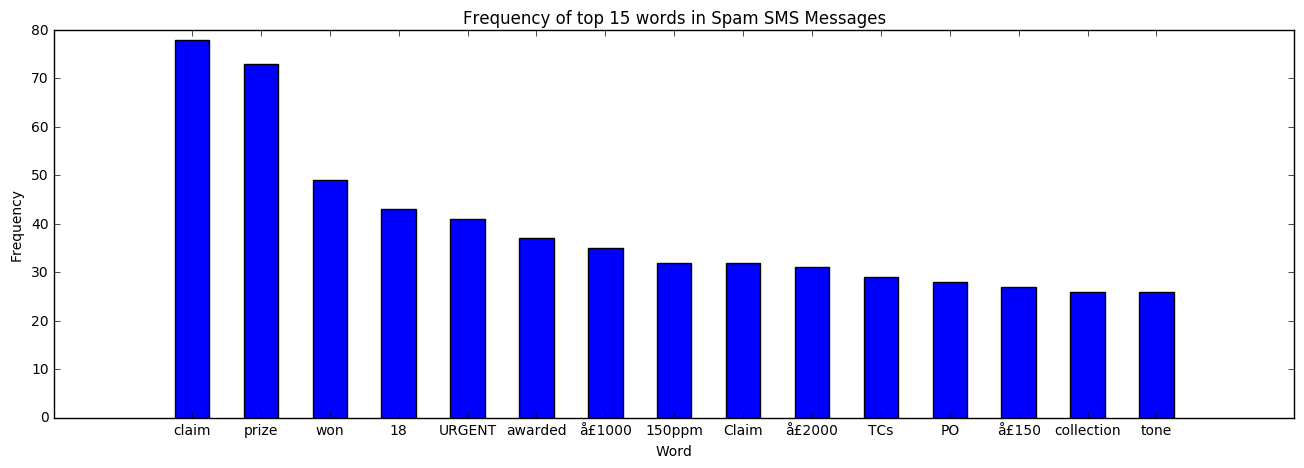

In [248]:
graph_x = list(sms_fifteen_largest.index)
graph_y = list(sms_fifteen_largest.get_values())
spacing = np.arange(len(graph_x)) #spacing between bars
plt.figure(figsize=(16,5))
plt.bar(spacing,graph_y,width=0.5,align='center',alpha=1.0)
plt.xticks(spacing,graph_x)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Frequency of top 15 words in Spam SMS Messages')
plt.show()

Through these transformations, we can conclude that text messages containing words relating to winning prizes or monetary values/symbols have a high likelihood of being a spam text message. The word 'prize' is the highest occurring word in the spam text messages, with 113 occurrences while the next three words are also related to winning or prizes. There also seem to be a trend of poor spacing or unpronounceable combinations of letters and numbers, which are common signs of spam messaging.  Next we will do the same analysis on emails. 

<a id='spam2'></a>
### Email Messages

Here, we do the same analysis as above with email data.

#### Finding The Top 50 Frequently Used Words in Spam Emails

##### Get frequency of words

In [249]:
#dictionaries of word -> num occurrences
spam_words = {} 
ham_words = {}

#used for stripping punctuation
translator= str.maketrans('','',string.punctuation) #for stripping punctuation

# First, we tokenize the words.
# To do this, we strip punctuation and split lines by spaces.
# Note that we do not convert to lowercase, so Free, free, and FREE 
# are all going to be different for our purposes.
# If a word isn't in it's respective dictionary (spam_words or ham_words),
# we add it with default value 1, otherwise we increment 
# the word's number of occurrences by 1. 

for item,row in email_spamham_data.iterrows():
    #remove punctuation
    line = row['Email'].translate(translator)
    #split by space
    line = line.split()
    
    for word in line:
        #if spam email, add it to spam_words hash
        if row['Spam or Ham'] == 'spam':
            if word in spam_words:
                spam_words[word] = spam_words[word] + 1
            else:
                spam_words[word] = 1
        #if ham email, add it to ham_words hash
        else: 
            if word in ham_words:
                ham_words[word] = ham_words[word] + 1
            else:
                ham_words[word] = 1

#creating dataframe for spam emails
email_spam_df = pd.DataFrame.from_dict(spam_words,orient='index')
#renaming columns
email_spam_df.columns = ['count']
#displaying dataframe
email_spam_df.head()

,count
clearance,15
innovative,10
experts,1
draw,8
teenporn,2


##### 50 most frequently used words in spam emails

In [250]:
email_spam_df['count'].nlargest(50)

email          1754
s              1572
order          1502
report         1315
address        1300
our            1183
mail           1173
program        1046
send           1032
free            953
list            942
receive         887
money           873
name            871
d               841
business        753
one             732
work            675
com             670
nt              662
internet        643
http            610
please          603
day             593
information     589
over            577
check           531
us              502
market          476
web             476
each            476
want            466
call            452
site            450
follow          437
remove          437
product         427
start           423
need            408
letter          403
week            401
here            393
service         390
every           381
software        380
include         376
credit          375
offer           373
many            350
best            349


#### Finding The Top 50 Frequently Used Words in Ham Emails

##### Get frequency of words

In [251]:
#creating dataframe for non-spam emails
email_ham_df = pd.DataFrame.from_dict(ham_words,orient='index')
#renaming columns
email_ham_df.columns = ['count']
#displaying dataframe
email_ham_df.head()

,count
avevo,1
clearance,1
innovative,3
predominately,1
draw,19


#### 50 most frequently used words in ham emails

In [252]:
email_ham_df['count'].nlargest(50)

language       1525
university     1268
s               878
linguistic      660
de              569
information     540
conference      495
workshop        479
english         477
e               420
email           418
one             398
paper           395
please          371
include         368
edu             364
research        351
address         350
abstract        340
http            335
fax             328
word            317
papers          315
h               315
d               302
speech          301
submission      283
theory          281
www             277
m               276
linguistics     269
system          268
follow          266
send            261
call            254
work            250
interest        246
l               240
c               238
book            235
study           235
case            234
session         234
form            233
usa             230
uk              230
o               219
page            219
first           217
g               216


### Finding Words Only In Spam Emails

##### Get frequency of words

In [253]:
# Get sets of all words in each dataframe
ham_set = set([ line for line in email_ham_df.index])
spam_set = set([ line for line in email_spam_df.index])

# Do set difference to get the words found in spam and not in ham
only_email_spam_set = spam_set.difference(ham_set)

# Filter the DataFrame
#This only contains the words used by spammers
only_email_spam_df = email_spam_df.ix[only_email_spam_set]
only_email_spam_df.head()

,count
teenporn,2
incidentals,4
capitalization,1
vme,2
updates,5


##### Top 50 words 

In [254]:
# getting top 50 words in spam email
email_largest = only_email_spam_df['count'].nlargest(50)
# top 15 words in spam email (for graphing)
email_fifteen_largest = only_email_spam_df['count'].nlargest(15)
#displaying top 50
email_largest

nbsp             196
capitalfm        196
ffa              183
floodgate        150
aol              133
bonus            119
mailing          118
investment       118
profit           111
hundred           95
reports           93
stealth           82
links             82
millions          75
always            75
offshore          73
sales             67
invest            62
tm                60
mlm               60
toll              56
amaze             55
recruit           55
album             54
mailer            52
xxx               51
spam              49
cent              48
goldrush          48
isp               48
cable             48
hottest           47
marketing         47
ems               46
boyfriend         45
tvsr              45
campaign          45
postage           44
undeliverable     43
sameday           43
chat              43
celebrity         43
fortune           42
addresses         41
unlimit           41
programs          40
guaranteed        40
resell       

##### Visualize The Data

Since the words we are graphing must be displayed on the X-axis, we have limited our graph to the top 15 words used by spammers. You can see that they correspond to the top 15 words in the email_largest dataframe. 

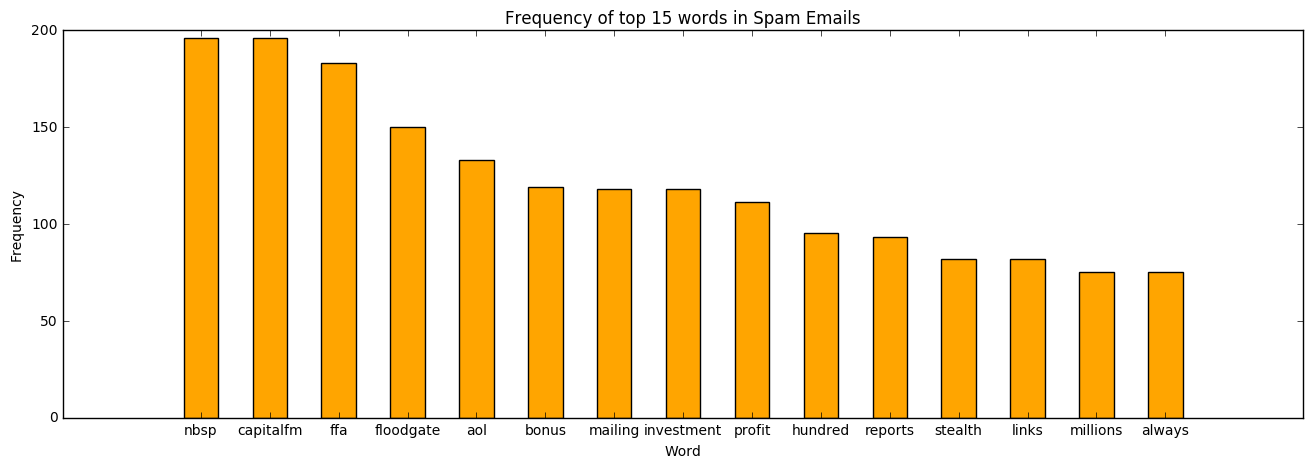

In [255]:
graph_x = list(email_fifteen_largest.index)
graph_y = list(email_fifteen_largest.get_values())
spacing = np.arange(len(graph_x))
plt.figure(figsize=(16,5))
plt.bar(spacing,graph_y,width=0.5,align='center',color = 'orange',alpha=1.0)
plt.xticks(spacing,graph_x)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Frequency of top 15 words in Spam Emails')
plt.show()

Through the transformations on email data, we can determine that there are fewer references to money—though 'investment' and 'millions' still made the list—and fewer shorthand acronyms.

## Finding the Most Common Words Across Spam Email and Spam SMS

So far, we've found the common words on SMS and email, respectively. Now, we are going to determine which words are most commonly used in both spam messages and spam emails. 

In [256]:
# Create sets of the data and do set intersection to get common words
email_spam = set([ line for line in only_email_spam_df.index])
SMS_spam = set([ line for line in only_SMS_spam_df.index])
common_words_set = email_spam.intersection(SMS_spam)

In [257]:
common = {}

# Creating a dict of the frequencies. 
# For each word, we add the count from 
# only_email_spam and only_SMS_spam
for word in common_words_set:
    common[word] = only_email_spam_df.ix[word]['count'] + only_SMS_spam_df.ix[word]['count']

# Making a dataframe of common words
common_words_df = pd.DataFrame.from_dict(common,orient='index')
# renaming columns
common_words_df.columns = ['count']
# displaying the dataframe
common_words_df.head()

,count
growing,4
sexiest,9
optin,8
horny,9
upgrade,28


#### Top 50 Words In Both Email and SMS Spam

In [258]:
# getting the top 50
common_largest = common_words_df['count'].nlargest(50)
# getting the top 15 (for graphing)
common_15_largest = common_words_df['count'].nlargest(15)
# displaying top 50
common_largest

bonus          121
guaranteed      66
won             52
marketing       48
unsubscribe     43
amazing         31
largest         30
upgrade         28
rental          21
stamped         21
premium         19
tips            19
newest          18
fraction        18
singles         17
dating          17
warranty        17
porn            16
fastest         16
recieve         15
abuse           14
tune            14
fantasy         14
charged         12
chart           12
bundle          11
passion         11
erotic          10
clip            10
sexiest          9
horny            9
entitled         9
spree            9
quiz             9
optin            8
discreet         7
customers        7
arsenal          7
records          6
improved         6
revealed         6
deals            6
delivered        6
companies        5
flag             5
optout           5
growing          4
loyalty          4
refused          4
cast             4
Name: count, dtype: int64

##### Visualize The Data

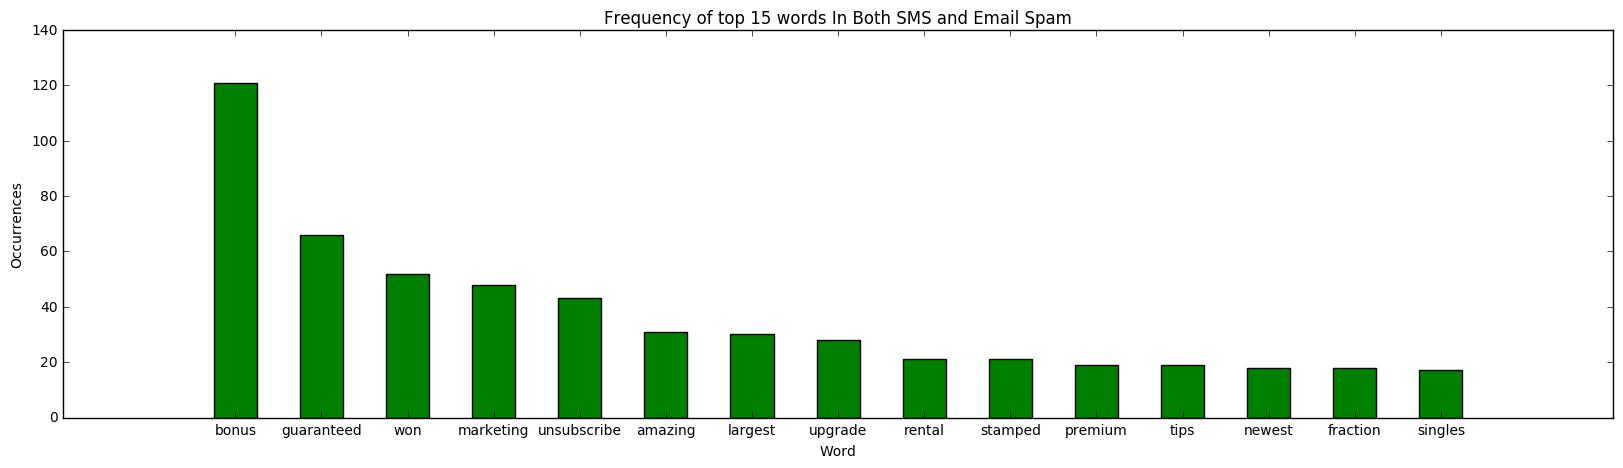

In [259]:
graph_x = list(common_15_largest.index)
graph_y = list(common_15_largest.get_values())
spacing = np.arange(len(graph_x))
plt.figure(figsize=(20,5))
plt.bar(spacing,graph_y,width=0.5,align='center',color = 'green',alpha=1.0)
plt.xticks(spacing,graph_x)
plt.xlabel('Word')
plt.ylabel('Occurrences')
plt.title('Frequency of top 15 words In Both SMS and Email Spam')
plt.show()

As demonstrated by the above dataframe and graph, words such as 'bonus', 'guaranteed', and 'won' are common across both SMS and email. Their prevalence indicates that scammers rely on ploys that involve telling the recipient that they have won something, regardless of platform. 

## Machine Learning

In [260]:
# We're adding a new column in the SMS dataframe with 0 and 1 indicating
# whether a message is spam or not. Spam == 1, ham == 0
SMS_spamham_data['sorh'] = np.where(SMS_spamham_data['Spam or Ham'] == 'spam', 
                                '1', '0')

# Creating a list of SMS messages and a corresponding list
# of whether that message is spam or ham
spam_train_data = list(SMS_spamham_data['SMS Message'])
spam_train_target = list(SMS_spamham_data['Spam or Ham'])

lb = preprocessing.LabelBinarizer()
spam_train_target = np.array([number[0] for number in lb.fit_transform(spam_train_target)])

#transforming data
count_vect = CountVectorizer(decode_error = 'replace')
X_train_counts = count_vect.fit_transform(spam_train_data)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

### Calculating Metrics

In [261]:
# method that calculates accuracy, f1 statistic,
# precision, and recall for a provided classifier. 

def calculate_metrics(classifier,name_of_classifier):
    
    classifier_score_list = []
    classifier_score_list.append(name_of_classifier)

    scores0 = cross_validation.cross_val_score(classifier, X_train_tfidf, spam_train_target, cv= 10, scoring = 'accuracy')
    data0 = "Accuracy: %0.4f" % (scores0.mean())
    classifier_score_list.append(data0)
        
    scores1 = cross_validation.cross_val_score(classifier, X_train_tfidf, spam_train_target, cv=10, scoring = 'f1')
    data1 = "f1: %0.4f " % (scores1.mean())
    classifier_score_list.append(data1)

    scores2 = cross_validation.cross_val_score(classifier, X_train_tfidf, spam_train_target, cv=10,scoring = 'precision')
    data2 = "Precision: %0.4f" % (scores2.mean())
    classifier_score_list.append(data2)

    scores3 = cross_validation.cross_val_score(classifier, X_train_tfidf, spam_train_target, cv=10, scoring = 'recall')
    data3 = "Recall: %0.4f" % (scores3.mean())
    classifier_score_list.append(data3)
    
    return classifier_score_list

### Evaluating Classifiers

Using scikit-learn, we can fit various classifiers on our data to determine which classifier would be better for training a spam filter. 

In [262]:
def evaluate_classifier(classifier):
        
    if classifier == "SVM":
        svm_clf = svm.SVC(kernel='linear', C=1).fit(X_train_tfidf,spam_train_target)
        classifier_metrics = calculate_metrics(svm_clf,classifier)

    elif classifier == "MultinomialNB":
        mnb_clf = MultinomialNB().fit(X_train_tfidf, spam_train_target)
        classifier_metrics = calculate_metrics(mnb_clf,classifier)

    elif classifier == "LinearSVC":
        lsvc_clf = svm.LinearSVC().fit(X_train_tfidf, spam_train_target)
        classifier_metrics = calculate_metrics(lsvc_clf,classifier)

    elif classifier == "SGD":
        sgd_clf = linear_model.SGDClassifier().fit(X_train_tfidf,spam_train_target)
        classifier_metrics = calculate_metrics(sgd_clf,classifier)

    elif classifier == "NearestCentroid":
        nc_clf = NearestCentroid().fit(X_train_tfidf,spam_train_target)
        classifier_metrics = calculate_metrics(nc_clf,classifier)

    elif classifier == "DecisionTree":
        dt_clf = tree.DecisionTreeClassifier(random_state = 0).fit(X_train_tfidf,spam_train_target)
        classifier_metrics = calculate_metrics(dt_clf,classifier)

    elif classifier == "AdaBoost":
        ab_clf = ensemble.AdaBoostClassifier().fit(X_train_tfidf,spam_train_target)
        classifier_metrics = calculate_metrics(ab_clf,classifier)

    elif classifier == "RandomForest":
        rf_clf = ensemble.RandomForestClassifier().fit(X_train_tfidf,spam_train_target)
        classifier_metrics = calculate_metrics(rf_clf,classifier)

    elif classifier == "KNeighbors":
        kn_clf = KNeighborsClassifier(n_neighbors = 3).fit(X_train_tfidf,spam_train_target)
        classifier_metrics = calculate_metrics(kn_clf,classifier)

    return classifier_metrics

In [263]:
#running the classifiers, getting their statistics, and printing them

SVM = evaluate_classifier("SVM")
MultinomialNB = evaluate_classifier("MultinomialNB")
LinearSVC = evaluate_classifier("LinearSVC")
SGD = evaluate_classifier("SGD")
NearestCentroid = evaluate_classifier("NearestCentroid")
DecisionTree = evaluate_classifier("DecisionTree")
AdaBoost = evaluate_classifier("AdaBoost")
RandomForest = evaluate_classifier("RandomForest")
KNeighbors = evaluate_classifier("KNeighbors")

print(SVM)
print(MultinomialNB)
print(LinearSVC)
print(SGD)
print(NearestCentroid)
print(DecisionTree)
print(AdaBoost)
print(RandomForest)
print(KNeighbors)

['SVM', 'Accuracy: 0.9842', 'f1: 0.9380 ', 'Precision: 0.9868', 'Recall: 0.8943']
['MultinomialNB', 'Accuracy: 0.9629', 'f1: 0.8385 ', 'Precision: 1.0000', 'Recall: 0.7230']
['LinearSVC', 'Accuracy: 0.9833', 'f1: 0.9341 ', 'Precision: 0.9869', 'Recall: 0.8875']
['SGD', 'Accuracy: 0.9849', 'f1: 0.9431 ', 'Precision: 0.9854', 'Recall: 0.9023']
['NearestCentroid', 'Accuracy: 0.9688', 'f1: 0.8826 ', 'Precision: 0.8897', 'Recall: 0.8768']
['DecisionTree', 'Accuracy: 0.9715', 'f1: 0.8913 ', 'Precision: 0.9082', 'Recall: 0.8767']
['AdaBoost', 'Accuracy: 0.9745', 'f1: 0.9004 ', 'Precision: 0.9432', 'Recall: 0.8634']
['RandomForest', 'Accuracy: 0.9743', 'f1: 0.8929 ', 'Precision: 0.9934', 'Recall: 0.7938']
['KNeighbors', 'Accuracy: 0.9244', 'f1: 0.6062 ', 'Precision: 1.0000', 'Recall: 0.4365']


#### Bar Graph Showing Classifier Accuracy

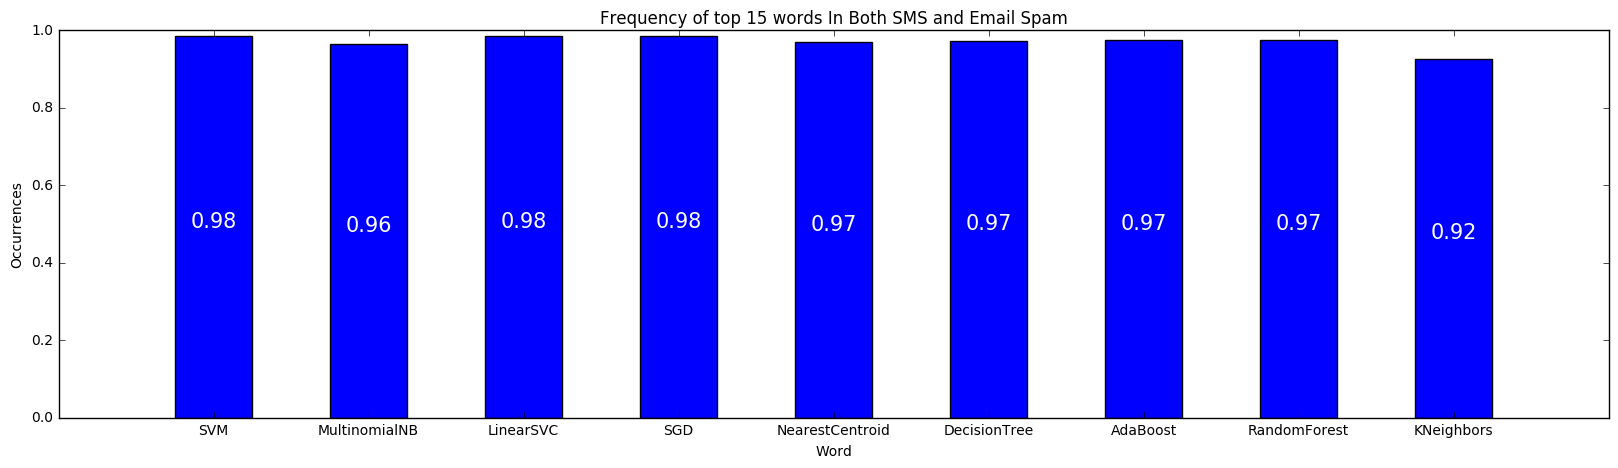

In [264]:
#Getting the accuracies as strings
accuracy_arr = [SVM[1][10:],MultinomialNB[1][10:],LinearSVC[1][10:],SGD[1][10:],NearestCentroid[1][10:],DecisionTree[1][10:],\
             AdaBoost[1][10:],RandomForest[1][10:],KNeighbors[1][10:]]

#converting strings to floats, so we can graph them
accuracy_arr = np.array(list(map(float, accuracy_arr))).tolist()

#array of classifier names
names_arr = ['SVM','MultinomialNB','LinearSVC','SGD','NearestCentroid','DecisionTree','AdaBoost','RandomForest','KNeighbors']

#plotting
spacing = np.arange(len(names_arr))
plt.figure(figsize=(20,5))
plt.bar(spacing,accuracy_arr,width=0.5,align='center',color = 'blue',alpha=1.0)
plt.xticks(spacing,names_arr)
plt.xlabel('Word')
plt.ylabel('Occurrences')
plt.title('Frequency of top 15 words In Both SMS and Email Spam')

# displaying the proportions in the middle of the respective bars
for i in spacing:
    plt.annotate("{:.2f}".format(accuracy_arr[i]),xy=(i-.15,accuracy_arr[i]/2), color='white',size=15)
    
plt.show()

In [265]:
## Next step: Training and testing classifier

In [266]:
def label(message):
        
    svm_clf = svm.SVC(kernel='linear', C=1).fit(X_train_tfidf,spam_train_target)
        
    docs_new = []
    docs_new.append(message)
        
    X_new_counts = count_vect.transform(docs_new)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = svm_clf.predict(X_new_tfidf)
        
    return predicted

In [269]:
label("claim your prize. You've won millions!!")[0]

1

In [270]:
label("Hi mom, how are you?")[0]

0

## Insight

## Summary and References

1. Kaggle: [https://www.kaggle.com/](https://www.kaggle.com/)
2. Scikit-Learn: [http://scikit-learn.org/stable/](http://scikit-learn.org/stable/)